In [1]:
import scipy
# import pulp
import os
import glob
import sys
import pylab
import random 
import numpy as np
import pandas as pd
# import networkx as nx
import matplotlib.pyplot as plt
#import sklearn as sk
#import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc

In [2]:
def summarize(mydf):
    for i in mydf.columns:
        print(i)
        if isinstance(np.array(mydf[i]),int)==True:
            print(np.mean(mydf[i]))

def dim(mydf):
    out = mydf.shape
    return out

def ndistinct(x):
    out = len(np.unique(x))
    print("There are", out, "distinct values.")


def gini(actual,pred,weight=None):
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort_values('Predicted')
    if weight is None:
        pdf['Weight'] = 1.0
  
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    return Gini 

def mylift(actual, pred, weight=None, n=10, xlab='Predicted Decile', MyTitle='Model Performance Lift Chart'):

    pdf = pd.DataFrame(scipy.vstack([actual, pred]).T, columns=['Actual', 'Predicted'])
    pdf = pdf.sort_values('Predicted')
    if weight is None:
        pdf['Weight'] = 1.0
  
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual'] * pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    NormalizedGini = Gini/ gini(pdf['Actual'], pdf['Actual'])
    GiniTitle = 'Normalized Gini = '+ str(round(NormalizedGini, 4))
    
    pdf['PredictedDecile'] = np.round(pdf['CummulativeWeight']*n /TotalWeight + 0.5, decimals=0)
    pdf['PredictedDecile'][pdf['PredictedDecile'] < 1.0] = 1.0
    pdf['PredictedDecile'][pdf['PredictedDecile'] > n] = n 
    
    pdf['WeightedPrediction'] = pdf['Predicted']*pdf['Weight']
    pdf['WeightedActual'] = pdf['Actual']*pdf['Weight']
    lift_df = pdf.groupby('PredictedDecile').agg(
        {
        'WeightedPrediction': np.sum,
         'Weight':np.sum,
         'WeightedActual':np.sum,
         'PredictedDecile':np.size}
    )
    nms = lift_df.columns.values
    nms[1] = 'Count'
    
    lift_df.columns = nms
    lift_df['AveragePrediction'] = lift_df['WeightedPrediction']/lift_df['Count']
    lift_df['AverageActual'] = lift_df['WeightedActual']/lift_df['Count']
    lift_df['AverageError'] = lift_df['AverageActual']/lift_df['AveragePrediction']
    
    return lift_df

def mylift2(actual,pred,weight=None,n=10,xlab='Predicted Decile',MyTitle='Model Performance Lift Chart'):
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort(columns='Predicted')
    if weight is None:
        pdf['Weight'] = 1.0
  
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    NormalizedGini = Gini/ gini(pdf['Actual'],pdf['Actual'])
    GiniTitle = 'Normalized Gini = '+ str(round(NormalizedGini,4))
    
    pdf['PredictedDecile'] = np.round(pdf['CummulativeWeight']*n /TotalWeight + 0.5,decimals=0)
    pdf['PredictedDecile'][pdf['PredictedDecile'] < 1.0] = 1.0
    pdf['PredictedDecile'][pdf['PredictedDecile'] > n] = n 
    
    pdf['WeightedPrediction'] = pdf['Predicted']*pdf['Weight']
    pdf['WeightedActual'] = pdf['Actual']*pdf['Weight']
    lift_df = pdf.groupby('PredictedDecile').agg({'WeightedPrediction': np.sum,'Weight':np.sum,'WeightedActual':np.sum,'PredictedDecile':np.size})
    nms = lift_df.columns.values
    nms[1] = 'Count'
    lift_df.columns = nms
    lift_df['AveragePrediction'] = lift_df['WeightedPrediction']/lift_df['Weight']
    lift_df['AverageActual'] = lift_df['WeightedActual']/lift_df['Weight']
    lift_df['AverageError'] = lift_df['AverageActual']/lift_df['AveragePrediction']
    
    d = pd.DataFrame(lift_df.index)
    p = lift_df['AveragePrediction']
    a = lift_df['AverageActual']
    pylab.plot(d,p,label='Predicted',color='blue',marker='o')
    pylab.plot(d,a,label='Actual',color='red',marker='d')
    pylab.legend(['Predicted','Actual'])
    pylab.title(MyTitle +'\n'+GiniTitle)
    pylab.xlabel(xlab)
    pylab.ylabel('Actual vs. Predicted')
    pylab.grid()
    pylab.show()


    
def deciles(var):
    out = []
    decile = [i * 10 for i in range(0,11)]
    for i in decile:
        out.append(np.percentile(var,i))
    
    outdf= pd.DataFrame()
    outdf['Decile'] = decile
    outdf['Value'] = out
    return outdf
    
def myauc(actual, pred):
    fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
    return metrics.auc(fpr, tpr)

def roc_plot(actual, pred, ttl):
    fpr, tpr, thresholds = roc_curve(actual, pred)
    roc_auc = auc(fpr, tpr)
    print("The Area Under the ROC Curve : %f" % roc_auc)
    # Plot ROC curve
    plt.clf()
    plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve'+'\n'+ttl)
    plt.legend(loc="lower right")
    plt.show()

def roc_perf(atrn, ptrn, atst, ptst):
    fprtrn, tprtrn, thresholds = roc_curve(atrn, ptrn)
    fprtst, tprtst, thresholdstst = roc_curve(atst, ptst)
    roc_auctrn= auc(fprtrn, tprtrn)
    roc_auctst = auc(fprtst, tprtst)
    print("The Training Area Under the ROC Curve : %f" % roc_auctrn)
    print("The Test Area Under the ROC Curve : %f" % roc_auctst)
    # Plot ROC curve
    plt.clf()
    plt.plot(fprtrn, tprtrn, color='red',label='Train AUC = %0.2f' % roc_auctrn)
    plt.plot(fprtst, tprtst, color='blue',label='Test AUC = %0.2f' % roc_auctst)
    plt.plot([0, 1], [0, 1], 'k')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def histogram(xvar,nbins=50):
    plt.hist(xvar,bins=nbins)
    plt.show()
        
def cdfplot(xvar):
    sortedvals=np.sort( xvar)
    yvals=np.arange(len(sortedvals))/float(len(sortedvals))
    plt.plot( sortedvals, yvals )
    plt.show()

def ptable(df, var, asc=False, topn = 100):
    outdf = df.groupby(var).count().reset_index().ix[:,0:2]
    outdf.columns = [outdf.columns[0],'Count']
    outdf = outdf.sort_values(by='Count',ascending=asc).reset_index(drop=True)
    outdf['Percent'] = outdf['Count'] / np.sum(outdf['Count'])

    if type(topn) == int:
        outdf = outdf.iloc[0:(topn),:]
        
    return outdf

def ptablebyv(df,var,sumvar,asc=False):
    outdf = df[[var,sumvar]].groupby(var).sum()
    outdf=outdf.reset_index().ix[:,0:2]
    outdf.columns = [outdf.columns[0],'Count']
    if asc==True:
    	outdf = outdf.sort(columns='Count',ascending=asc)
    outdf['Percent'] = outdf['Count'] / np.sum(outdf['Count'])
    return outdf

def barplot(df, var, MyTitle="", aval=0.9, prnt=False, prcnt=False, topn=10):
    # Taken from a pandas summary file
    out = ptable(df, var, asc=False, topn=topn)
    
    if prcnt==True:
        out = out.sort_values("Percent").reset_index()
        out[['Percent']].plot(kind='barh', figsize=(16,8))
    else:
        out = out.sort_values("Count").reset_index()
        out[['Count']].plot(kind='barh', figsize=(16,8))
        
    if prnt == True:
        print(out)
        
    plt.yticks(out.index, out[var])
    plt.xlabel('')
    plt.title(MyTitle)
    plt.grid()
    plt.show()

def Build_STDM(docs, **kwargs):
    ''' Build Spares Term Document Matrix '''
    vectorizer = CountVectorizer(**kwargs)
    sparsematrix= vectorizer.fit_transform(docs)
    vocab = vectorizer.vocabulary_.keys()
    return sparsematrix, vocab

In [3]:
plt.figure(figsize=(3, 3))
plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
plt.title('Page One')

In [6]:
all_scores = pd.read_csv('../Results/fitted_notuning_20pct.txt')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:71: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


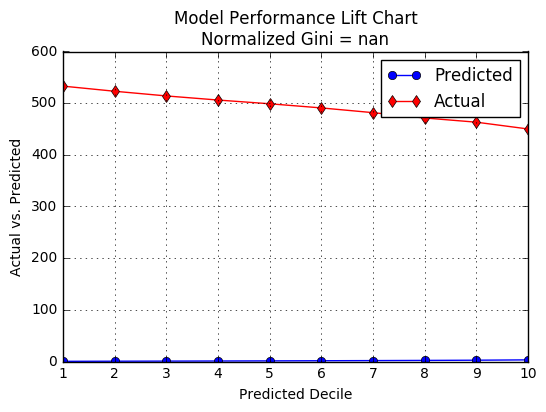

In [10]:
mylift2(all_scores.SCORE01_B01, all_scores.PRED)